# Assignment 4: Bikeshare Project

This project examines the publicly available GCP bikeshare dataset and provides a number of recommendations to Ford Bikeshare towards growing its user base and revenues. Some of the incentives that were examined include:

    - Day of week based incentives
    - Incentivizing popular weekend routes
    - Incentivizing popular weekday routes
    - Incentivizing subscribers vs customers
    
The sections following "data cleansing" go over each of the above in more detail providing queries and recommendations for each section.


In [1]:
import pandas as pd
%matplotlib inline

#### Data cleansing
Before using the dataset, I did a small amount of cleansing to remove trips that are less than 2 minutes and greater than 10 hours. I used this cleaned up data set for the queries below

In [28]:
! bq query --use_legacy_sql=false '\
SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips` \
WHERE NOT (duration_sec > 20*3600 OR duration_sec  < 2 *  60) \
LIMIT 5 \
'

Waiting on bqjob_r1dca9b67a2829edb_00000168c845fcb8_1 ... (0s) Current status: DONE   
+---------+--------------+---------------------+--------------------+------------------+---------------------+------------------+----------------+-------------+----------+-----------------+
| trip_id | duration_sec |     start_date      | start_station_name | start_station_id |      end_date       | end_station_name | end_station_id | bike_number | zip_code | subscriber_type |
+---------+--------------+---------------------+--------------------+------------------+---------------------+------------------+----------------+-------------+----------+-----------------+
|  944732 |         2618 | 2015-09-24 17:22:00 | Mezes              |               83 | 2015-09-24 18:06:00 | Mezes            |             83 |         653 | 94063    | Customer        |
|  984595 |         5957 | 2015-10-25 18:12:00 | Mezes              |               83 | 2015-10-25 19:51:00 | Mezes            |             83 |       

This was saved as reliable-jet-228900.bike_trip_data.bikeshare_trips_clean. The reduced dataset had 975375 rows (down from 983648)

In [29]:
! bq query --use_legacy_sql=false ' \
SELECT COUNT(*) \
FROM `reliable-jet-228900.bike_trip_data.bikeshare_trips_clean` \
'

Waiting on bqjob_r5d3d7dc73e664ac7_00000168c8473d25_1 ... (0s) Current status: DONE   
+--------+
|  f0_   |
+--------+
| 975375 |
+--------+


### 1. Day of week based incentives
It is likely that customers use bikeshare more frequently during certain days of the week compared to other days. We will perform some queries to figure out which days see lesser bikeshare traffic and figure out how to increase traffic on these days. 

First we will perform a query to figure out the sum of the durations_sec and sort them by day of week

In [2]:
! bq query --use_legacy_sql=false --format=csv ' \
SELECT EXTRACT (DAYOFWEEK from start_date) as day_of_week, SUM(duration_sec) as trip_length_sum_per_week \
FROM `reliable-jet-228900.bike_trip_data.bikeshare_trips_clean` \
GROUP BY day_of_week \
ORDER BY day_of_week; \
' > trip_len.csv

Waiting on bqjob_r57c2b7522e45b8f6_00000168c83e31e2_1 ... (0s) Current status: DONE   

In [3]:
trip_len_data = pd.read_csv("trip_len.csv")

In [4]:
trip_len_data

,day_of_week,trip_length_sum_per_week
0,1,105157765
1,2,129606217
2,3,133755198
3,4,132861324
4,5,132638530
5,6,135725265
6,7,115718564


In [5]:
trip_len_data["day"] = ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday')

In [6]:
trip_len_data["total_trip_hours"] = trip_len_data["trip_length_sum_per_week"] / 3600

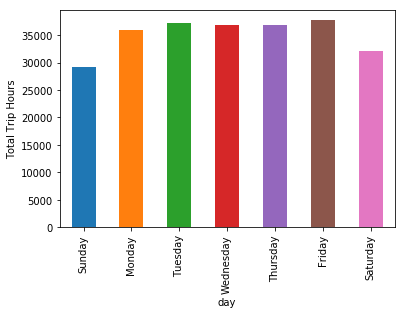

In [12]:
plt1 = trip_len_data.plot(x = 'day', y = 'total_trip_hours', kind = 'bar', legend = False)
plt1.set_ylabel ("Total Trip Hours");

Clearly as we can see Friday has the most trips, while Sunday has the least. Ford Bikeshare has to figure out how to incentivize customers over the weekends, especially Sunday. During weekdays, Friday is the busiest. 

In addition to figuring out how to incentivize customers, it also makes sense to figure out which are the most common trips over the weekend so as to provide further incentives to customers to take these trips. This is discussed in the next section.

#### Recommendation Set 1:
    - Provide coupons on the mobile app for customers to redeem on Saturday and Sunday


### 2. Incentivizing popular weekend routes

As we saw earlier, Ford Bikeshare needs to incentivize customers to increase business by at least 20% to hit Friday highs. One way to do this is to figure out the popular routes and incentivize customers to use bikeshare for these routes. What would help here is to figure out the most popular routes during weekends. We do this using the query below

In [11]:
! bq query --use_legacy_sql=false --format=csv ' \
SELECT trip_name, COUNT(trip_name) as trip_frequency_weekends \
FROM ( \
   SELECT CONCAT(start_station_name, "_", end_station_name) as trip_name, \
   EXTRACT (DAYOFWEEK from start_date) as day_of_week \
   FROM `reliable-jet-228900.bike_trip_data.bikeshare_trips_clean` \
   ORDER BY trip_name \
   ) \
   where day_of_week = 1 or day_of_week = 7 \
GROUP BY trip_name \
ORDER BY trip_frequency_weekends DESC \
LIMIT 10; \
' > pop_trips_wknds.csv;

Waiting on bqjob_r6311c45c28b24e97_00000168c83ea30b_1 ... (0s) Current status: DONE   

In [9]:
pop_trips_wknds = pd.read_csv('pop_trips_wknds.csv')

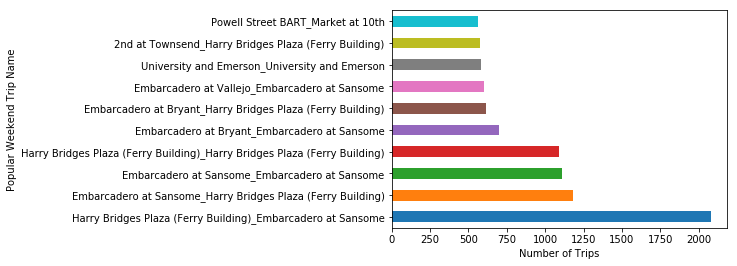

In [10]:
plt2 = pop_trips_wknds.plot( x = 'trip_name', y = 'trip_frequency_weekends', kind = 'barh', 
                            legend = False, fontsize = 10)
plt2.set_xlabel ("Number of Trips")
plt2.set_ylabel ("Popular Weekend Trip Name");

As we can see above, there are a few popular trips and popular stations that seem to be used more often over the weekends. This information can be put to marketing use so that Ford can advertize these routes and offer incentives to customers to use these routes more frequently over the weekends

#### Recommendation Set 2:
    - Advertize the above 10 most popular routes on the mobile app (using pictures of landmarks etc)
    - Provide discounted flat rates for these trips on the mobile app (ex : $10/hour for a 5-hour trip )

### 3. Incentivizing popular weekday routes

Incentivizing weekday routes in addition to weekend routes is likely going to help with increasing revenues. How do we identify the popular weekday routes? The following query helps 

In [14]:
! bq query --use_legacy_sql=false --format=csv ' \
SELECT trip_name, COUNT(trip_name) as trip_frequency_weekdays \
FROM ( \
   SELECT CONCAT(start_station_name, "_", end_station_name) as trip_name, \
   EXTRACT (DAYOFWEEK from start_date) as day_of_week \
   FROM `reliable-jet-228900.bike_trip_data.bikeshare_trips_clean` \
   ORDER BY trip_name \
   ) \
   where day_of_week > 1 and day_of_week < 7 \
GROUP BY trip_name \
ORDER BY trip_frequency_weekdays DESC \
LIMIT 10; \
' > pop_trips_wkdays.csv

Waiting on bqjob_r15807da06cb96151_00000168c83f7346_1 ... (0s) Current status: DONE   

In [15]:
pop_trips_wkdays = pd.read_csv('pop_trips_wkdays.csv')

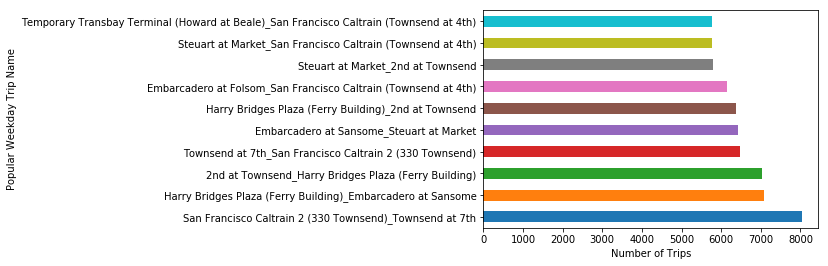

In [16]:
plt3 = pop_trips_wkdays.plot( x = 'trip_name', y = 'trip_frequency_weekdays', kind = 'barh', 
                            legend = False, fontsize = 10)
plt3.set_xlabel ("Number of Trips")
plt3.set_ylabel ("Popular Weekday Trip Name");

Similar to the weekends, there are a few popular trips and popular stations that seem to be used more often over the weekdays. However, while the weekend users are likely to be largely tourists, the weekday users are likely to be commuters to work who will use the bikeshare anyway. 

Perhaps it makes sense to incentivize the users of these routes to use the trips more frequently by making it easy for them to use bikeshare. It is possible that some of them don't use bikeshare frequently because they either don't find bikes or docking stations. For these popular routes, we can try to enable ways to reserve bikes/docking stations ahead of time.

Another way is to provide incentives to office mates who might be taking the same route. If a subscriber helps sign up an office mate who is likely to take the same route, Ford Bikeshare might want to provide additional coupons to him/her. All of these could be route based. 


#### Recommendation Set 3:
    - Using location based monitoring, identify if a subscriber uses one of these 10 popular routes on a daily basis
    - Using  mobile app, provide option to subscribers to pre-book a bike and docking station for these popular commutes for a small incremental price
    - Provide frequent user points on the mobile app to subscribers who use these 10 routes frequently
    - Provide coupons to subscribers for signing up an office mate to use bikeshare for these 10 routes

### 4. Incentivizing Subscribers vs Customers

As we have seen above, it makes sense to incentivize users of bikeshare for the popular routes. But should Ford be incentivizing Subscribers or non-subscribers (aka "Customers" in the database).
The following queries should help identify which section of people to incentivize and whether Ford should focus on weekends or weekdays.

In [17]:
! bq query --use_legacy_sql=false --format csv ' \
SELECT subscriber_type, COUNT(trip_id) as trip_count_weekdays \
FROM ( \
   SELECT subscriber_type, trip_id, EXTRACT (DAYOFWEEK from start_date) as day_of_week \
   FROM `reliable-jet-228900.bike_trip_data.bikeshare_trips_clean` \
   ) \
WHERE day_of_week > 1 and day_of_week < 7 \
GROUP BY subscriber_type \
ORDER BY subscriber_type; \
' > cust_prof_trip_count_weekdays

Waiting on bqjob_r428b78adc0f5735c_00000168c83fa999_1 ... (0s) Current status: DONE   

In [18]:
! bq query --use_legacy_sql=false --format csv '\
SELECT subscriber_type, SUM(trip_length_sum_weekdays) as total_trip_length_weekdays \
FROM ( \
   SELECT subscriber_type, EXTRACT (DAYOFWEEK from start_date) as day_of_week, SUM(duration_sec) as trip_length_sum_weekdays \
   FROM `reliable-jet-228900.bike_trip_data.bikeshare_trips_clean` \
   GROUP BY subscriber_type, day_of_week \
   ) \
   WHERE day_of_week >1 and day_of_week < 7 \
   GROUP BY subscriber_type \
   ORDER BY subscriber_type; \
' > cust_prof_trip_length_weekdays

Waiting on bqjob_r471c2962b7a27b25_00000168c83fb44f_1 ... (0s) Current status: DONE   

In [19]:
! bq query --use_legacy_sql=false --format csv ' \
SELECT subscriber_type, COUNT(trip_id) as trip_count_weekends \
FROM ( \
   SELECT subscriber_type, trip_id, EXTRACT (DAYOFWEEK from start_date) as day_of_week \
   FROM `reliable-jet-228900.bike_trip_data.bikeshare_trips_clean` \
   ) \
WHERE day_of_week = 1 or day_of_week = 7 \
GROUP BY subscriber_type \
ORDER BY subscriber_type; \
' > cust_prof_trip_count_weekends

Waiting on bqjob_r188a3221dc4f2a98_00000168c83fbebb_1 ... (0s) Current status: DONE   

In [20]:
! bq query --use_legacy_sql=false --format csv '\
SELECT subscriber_type, SUM(trip_length_sum_weekends) as total_trip_length_weekends \
FROM ( \
   SELECT subscriber_type, EXTRACT (DAYOFWEEK from start_date) as day_of_week, SUM(duration_sec) as trip_length_sum_weekends \
   FROM `reliable-jet-228900.bike_trip_data.bikeshare_trips_clean` \
   GROUP BY subscriber_type, day_of_week \
   ) \
   WHERE day_of_week = 1 or day_of_week = 7 \
   GROUP BY subscriber_type \
   ORDER BY subscriber_type; \
' > cust_prof_trip_length_weekends

Waiting on bqjob_r39d27ac3373c30b5_00000168c83fc920_1 ... (0s) Current status: DONE   

In [21]:
cust_prof_trip_count_weekdays = pd.read_csv("cust_prof_trip_count_weekdays")
cust_prof_trip_count_weekdays.set_index('subscriber_type', inplace = True)
cust_prof_trip_count_weekends = pd.read_csv("cust_prof_trip_count_weekends")
cust_prof_trip_count_weekends.set_index('subscriber_type', inplace = True)
cust_prof_trip_length_weekdays = pd.read_csv("cust_prof_trip_length_weekdays")
cust_prof_trip_length_weekdays.set_index('subscriber_type', inplace = True)
cust_prof_trip_length_weekends = pd.read_csv("cust_prof_trip_length_weekends")
cust_prof_trip_length_weekends.set_index('subscriber_type', inplace = True)

In [22]:
frames = [cust_prof_trip_count_weekdays, cust_prof_trip_count_weekends,cust_prof_trip_length_weekdays, cust_prof_trip_length_weekends]
customer_profile = pd.concat(frames, axis = 1)

In [23]:
customer_profile

,trip_count_weekdays,trip_count_weekends,total_trip_length_weekdays,total_trip_length_weekends
subscriber_type,,,,
Customer,80992,54613,221989742,185184278
Subscriber,783937,55833,442596792,35692051


In [24]:
customer_profile['avg_trip_len_weekdays'] = customer_profile['total_trip_length_weekdays']/customer_profile['trip_count_weekdays']

In [25]:
customer_profile['avg_trip_len_weekends'] = customer_profile['total_trip_length_weekends']/customer_profile['trip_count_weekends']

In [27]:
customer_profile

,trip_count_weekdays,trip_count_weekends,total_trip_length_weekdays,total_trip_length_weekends,avg_trip_len_weekdays,avg_trip_len_weekends
subscriber_type,,,,,,
Customer,80992,54613,221989742,185184278,2740.884803,3390.846099
Subscriber,783937,55833,442596792,35692051,564.582093,639.264431


From the above summary of the customer profile, we can gather a few important observations:
    - Subscribers generally take shorter but more frequent trips during weekdays. These are likely the working class commuters
    - Customers generally take longer trips than subscribers, especially over weekends. These are likely tourists with families

#### Recommendation Set 4:
    - Provide loyalty points to subcribers based on weekday trips that allow them to get free trips (ex: one free 30 minute trip for 10 trips taken)
    - Offer one time incentive to customers for converting themselves into subscribers (ex: 5 hours of free rides)
    - Using mobile app, Offer bundle deals to families over weekends (ex: discount of x% for family of four)


#### Conclusions and future work
The report provides some recommendations to increase user base and revenue for Ford Bikeshare based on SQL analysis of the bikeshare_trips public database using Google BigQuery. Based on the findings, it is recommended that Ford Bikeshare provide differentiated initiatives to subscribers and non-subscribers based on popular routes, weekends vs weekdays, and tourists vs commuters.

For further analysis, Ford Bikeshare could combine information on its own customers with this trip database to provide incentives tailored to its customer base. In particular, there has to be more work done in figuring out pricing models for the discounts and incentives described in this report.